# Variogram analysis and kriging for data in 3D (general)

Interpolate a data set in 3D, using ordinary kriging. Starting from a data set in 3D, the following is done:
- basic exploratory analysis: variogram cloud / experimental variogram
- fitting a covariance / variogram model, and cross-validation (LOO error)
- interpolation by ordinary kriging, simple kriging (and simulation)

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import time

# import from package 'geone'
import geone.covModel as gcm
import geone.geosclassicinterface as gci
import geone.grf as grf
import geone.img as img
#import geone.imgplot as imgplt
import geone.imgplot3d as imgplt3
#import geone.customcolors as ccol

## Preparation - build a data set in 3D

A data set in 3D is extracted from a Gaussian random field generated based on a known covariance model, called the *reference model* which will be considered as unknown further.

Define a (anisotropic) *reference* covariance model in 3D (class `covModel3D` from `geone.covModel`, see jupyter notebook `ex_grf_3d`).

In [2]:
cov_model_ref = gcm.CovModel3D(elem=[
    ('spherical', {'w':9.5, 'r':[20, 10, 5]}), # elementary contribution (different ranges: anisotropic)
    ('nugget', {'w':0.5})                       # elementary contribution
    ], alpha=30.0, beta=-40.0, gamma=20.0, name='ref model (anisotropic)')

In [3]:
cov_model_ref

Covariance model 3D: (Name = ref model (anisotropic))
   2 elementary contribution(s)
   Elementary contribution 0: type : spherical
      parameters:  w = 9.5,  r = [20, 10, 5]
   Elementary contribution 1: type : nugget
      parameters:  w = 0.5
   Angles: alpha = 30.0 deg., beta = -40.0 deg., gamma = 20.0 deg.
   i.e.: the system Ox'''y''''z''', supporting the axes of the model (ranges),
         is obtained from the system Oxyz as follows:
         Oxyz      -- rotation of angle -alpha around Oz  --> Ox'y'z'
         Ox'y'z'   -- rotation of angle -beta  around Ox' --> Ox''y''z''
         Ox''y''z''-- rotation of angle -gamma around Oy''--> Ox'''y'''z'''

Generate a gaussian random field in 3D (see function `grf3D` from `geone.grf`), and extract data points:
- `n`: number of data points, 
- `x`: location of data points (2-dimensional array of shape `(n, 3)`, each row is a point),
- `v`: values at data points (1-dimensional array of length `n`).

In [4]:
# Simulation grid (domain)
nx, ny, nz = 65, 64, 60     # number of cells
dx, dy, dz = 0.5, 0.5, 0.5  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

# Reference simulation
np.random.seed(123)
ref = grf.grf3D(cov_model_ref, (nx, ny, nz), (dx, dy, dz), (ox, oy, oz), nreal=1, printInfo=False) 
    # 4d-array of shape 1 x nz x ny x nx

# Extract n points from the reference simulation
n = 150 # number of data points
ind = np.random.choice(nx*ny*nz, size=n, replace=False) # indexes of extracted grid cells
iz = ind//(nx*ny) # indexes along z-axis
ii = ind%(nx*ny)
iy = ii//nx # indexes along y-axis
ix = ii%nx  # indexes along x-axis
xc = ox + (ix + 0.5)*dx # x-coordinates of data points (centers of the extracted grid cells)
yc = oy + (iy + 0.5)*dy # y-coordinates of data points (centers of the extracted grid cells)
zc = oz + (iz + 0.5)*dz # z-coordinates of data points (centers of the extracted grid cells)
#xc = ox + (ind + np.random.random(n))*dx # x-coordinates of data points (within the extracted grid cells)
#yc = oy + (ind + np.random.random(n))*dy # y-coordinates of data points (within the extracted grid cells)
#zc = oz + (ind + np.random.random(n))*dz # z-coordinates of data points (within the extracted grid cells)

x = np.array((xc, yc, zc)).T # array of coordinates of data points (shape: n x 3)
v = ref[0].reshape(-1)[ind] # value at data points

In [5]:
# Plot covariance model in 3D
#cov_model_ref.plot_model3d_volume()

In [6]:
# Plot covariance model in 3D in an interactive figure
#pp = pv.Plotter(notebook=False) # open a plotter and specifying 'notebook=False'
#cov_model_ref.plot_model3d_volume(plotter=pp)
#pp.show() # show the figure: after closing the pop-up window, the position of the camera is retrieved in output.

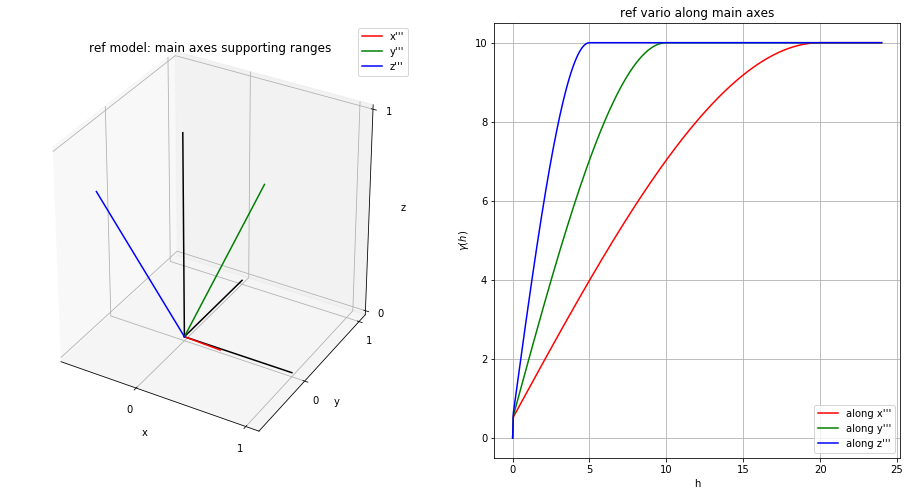

In [7]:
# Plot main axes supporting ranges and vario model curves along each main axis
fig = plt.figure(figsize=(16,8))

# ...plot main axes
fig.add_subplot(1,2,1, projection='3d')
cov_model_ref.plot_mrot(set_3d_subplot=False)
plt.title('ref model: main axes supporting ranges')

# ...plot variogram model curves along each main axis
fig.add_subplot(1,2,2)
cov_model_ref.plot_model_curves(vario=True)
plt.title('ref vario along main axes')
plt.show()

In [8]:
# Preparation for plotting reference simulation and data points

# fill image (Img class from geone.img) for view
im_ref = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=1, val=ref)

# data_points: to be added to 3D plot
data_points = pv.PolyData(x)

# ... set color for data points according to their value
cmap = plt.get_cmap('terrain') # color map
cmin = im_ref.vmin()[0] # min value in ref
cmax = im_ref.vmax()[0] # max value in ref
data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points['colors'] = data_points_col

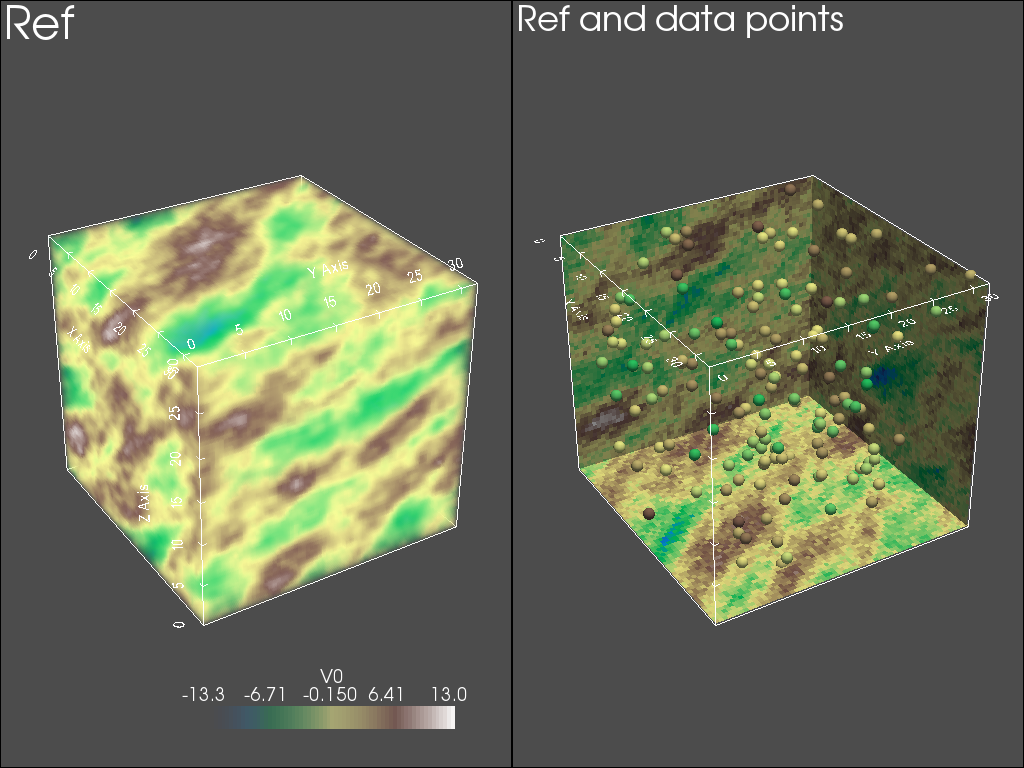

In [9]:
# Plot reference simulation and data points

# Plot "interactive" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,2))

# ... plot 
pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_ref, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Ref') # title
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im_ref, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+0.5*dx,
                          slice_normal_y=oy+(ny-0.5)*dy,
                          slice_normal_z=oz+0.5*dz,
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='Ref and data points') # title                          
pp.add_mesh(data_points, cmap=cmap, rgb=True, point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

## Start from a data set in 3D
- `n`: number of data points, 
- `x`: location of data points (2-dimensional array of shape `(n, 3)`, each row is a point),
- `v`: values at data points (1-dimensional array of length `n`).

Visualise the data set and the histogram of values.

In [10]:
# Set data_points
data_points = pv.PolyData(x)
data_points['data value'] = v

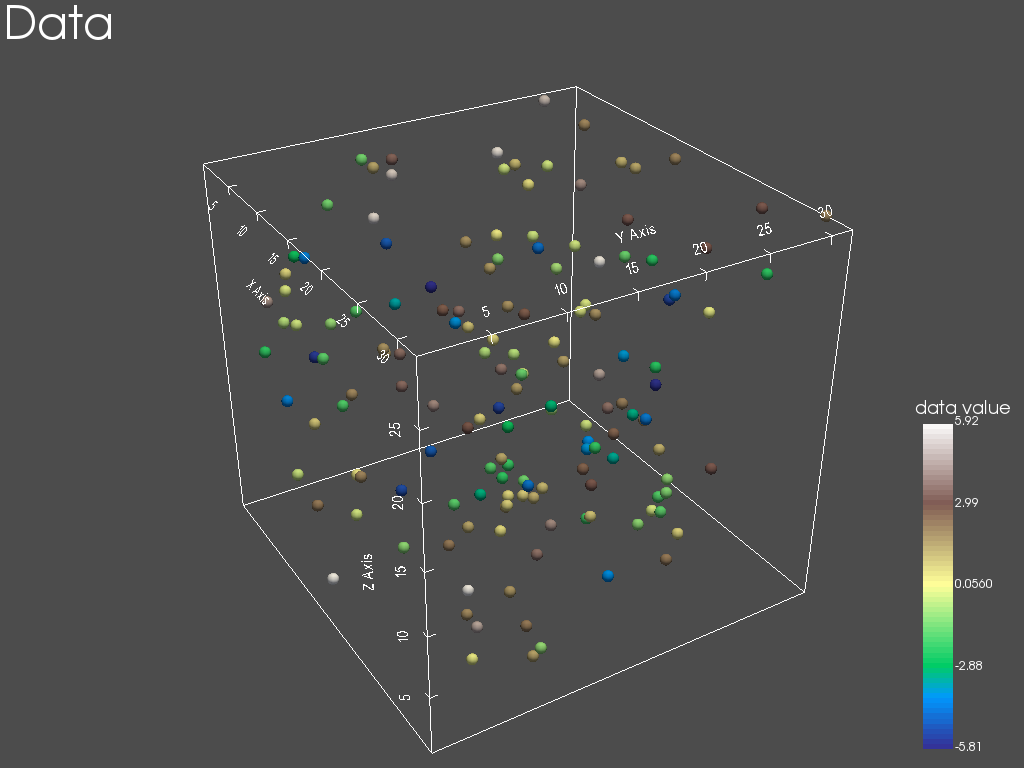

In [11]:
# Plot data points in 3D

# Plot "interactive" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(notebook=False)
# ... inline
pp = pv.Plotter()

pp.add_mesh(data_points, cmap=cmap, point_size=12., render_points_as_spheres=True, 
            scalar_bar_args={'vertical':True, 'title_font_size':18})
pp.add_mesh(data_points.outline())
pp.show_bounds()
pp.add_text('Data')

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

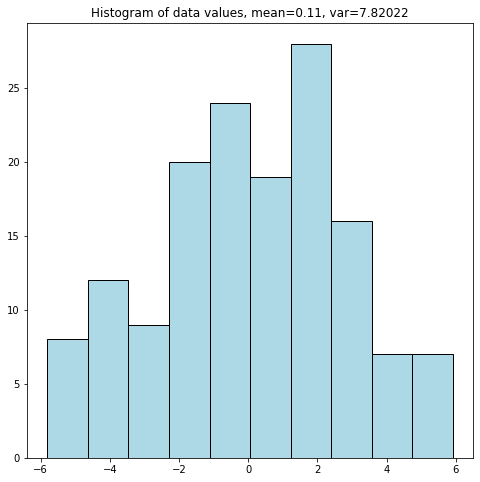

In [12]:
# Plot histogram of data values
plt.figure(figsize=(8,8))
plt.hist(v, color='lightblue', edgecolor='black')
plt.title('Histogram of data values, mean={:.2g}, var={:2g}'.format(np.mean(v), np.var(v)))
plt.show()

### Model fitting
The function `covModel3D_fit` is used to fit a covariance model in 3D (class `covModel3D`).

This function takes as first argument the location of the data points, as second argument the values at the data points, and at third argument a covariance model in 3D with given type of elementary contributions and with parameters to fit set to `nan`. It returns the optimal covariance model and the vector of optimal parameters.

This function is based on the function `curve_fit` from `scipy.optimize` module. It fits the curve of the variogram model to the points $(h, \gamma(h))$, where $h$ is the lag between a pair of data points and $\gamma(h)$ is the half of the square of the difference of the values at these points. Hence, the fitting does not depend on the experimental variogram (see further), *i.e.* on the choice of direction or classes for the lags.

The function `covModel3D_fit` also takes the keyword argument `hmax`, which specifies the maximal distance between two data points to be integrated in the fitting. Note that a plot of the optimal model returned is made by default (keyword argument `make_plot=True`).

#### Bounds for parameters to fit
Bounds for parameters to fit can be specified to avoid meaningless optimal parameters returned (*e.g.* negative weight or range). Such bounds are given to the function `covModel3D_fit` (and then to the function `curve_fit` from `scipy.optimize`) via the keyword arguments `bounds=(<array of lower bounds>, <array of upper bounds>)`, where the arrays of lower / upper bounds have the same length as the vector of parameters to fit, with the $i-$th entry corresponding to the $i$-th parameter to fit (set to `nan`) in the covariance model passed as third argument. Note also that the keyword argument `p0` allows to specify a vector of initial parameters (see doc of function `curve_fit`).

In [13]:
cov_model_to_optimize = gcm.CovModel3D(
    elem=[('gaussian',    {'w':np.nan, 'r':[np.nan, np.nan, np.nan]}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':[np.nan, np.nan, np.nan]}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':[np.nan, np.nan, np.nan]}), # elementary contribution
          ('nugget',      {'w':np.nan})                        # elementary contribution
         ], alpha=np.nan, beta=np.nan, gamma=np.nan, name='')

cov_model_opt, popt = gcm.covModel3D_fit(x, v, cov_model_to_optimize, #hmax=150,
    bounds=([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  .1, -90, -90, -90],  # min value for param. to fit
            [20, 30, 30, 30, 20, 30, 30, 30, 20, 30, 30, 30,   2,  90,  90,  90]), # max value for param. to fit
             # gaus. contr.,   sph. contr. ,   exp. contr. , nug., angles: alpha, beta, gamma
    make_plot=False)
cov_model_opt

Covariance model 3D: (Name = )
   4 elementary contribution(s)
   Elementary contribution 0: type : gaussian
      parameters:  w = 1.5439059954127507e-08,  r = [7.2424442496765735, 25.4592345659346, 5.116070794232457]
   Elementary contribution 1: type : spherical
      parameters:  w = 7.857269618630478,  r = [8.79895123274748, 29.999995582767575, 5.703598351839971]
   Elementary contribution 2: type : exponential
      parameters:  w = 5.800025842285344e-07,  r = [29.261742786568014, 3.26297718935676, 14.625674602979752]
   Elementary contribution 3: type : nugget
      parameters:  w = 0.14870009682504118
   Angles: alpha = -44.688194433055926 deg., beta = 7.157289630279509 deg., gamma = 43.9945142324671 deg.
   i.e.: the system Ox'''y''''z''', supporting the axes of the model (ranges),
         is obtained from the system Oxyz as follows:
         Oxyz      -- rotation of angle -alpha around Oz  --> Ox'y'z'
         Ox'y'z'   -- rotation of angle -beta  around Ox' --> Ox''y''z''
 

In [14]:
## Plot the covariance model obtained
##  slice orthogonal to main axes in a 3D block
#cov_model_opt.plot_model3d_slice()

In [15]:
## Plot the covariance model obtained in an interactive figure
##  slice orthogonal to main axes in a 3D block
#pp = pv.Plotter(notebook=False)
#cov_model_opt.plot_model3d_slice(plotter=pp)
#pp.show()

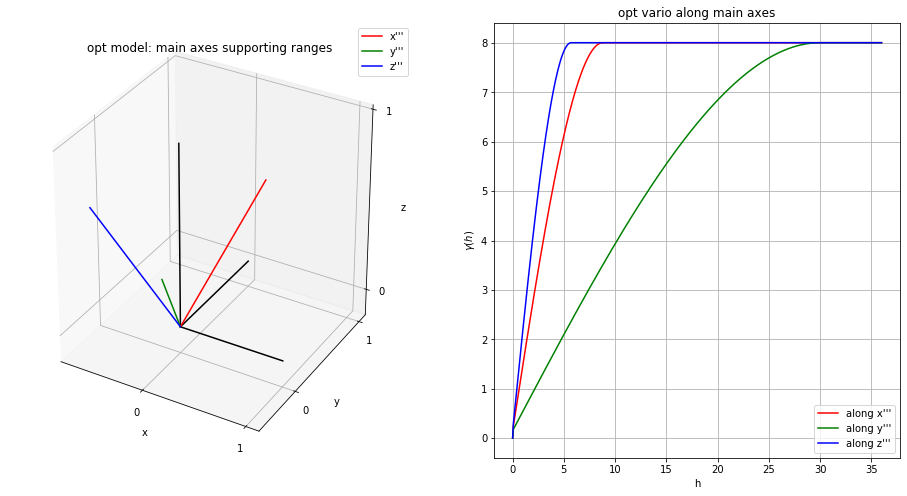

In [16]:
# Plot main axes supporting ranges and vario model curves along each main axis
fig = plt.figure(figsize=(16,8))

# ...plot main axes
fig.add_subplot(1,2,1, projection='3d')
cov_model_opt.plot_mrot(set_3d_subplot=False)
plt.title('opt model: main axes supporting ranges')

# ...plot variogram model curves along each main axis
fig.add_subplot(1,2,2)
cov_model_opt.plot_model_curves(vario=True)
plt.title('opt vario along main axes')
plt.show()

### Check with the experimental variograms in the main directions (derived from optimal angles retrieved)
The function `variogramExp3D` computes three directional exprimental variograms for a data set in 3D: one along each main axis ($x'''$, $y'''$ and $z'''$). The system $Ox'''y'''z'''$ is defined from the angle alpha, beta and gamma (keyword arguments `alpha`, `beta` and `gamma`) in the same way as for covariance model in 3D.

The keyword arguments `tol_dist` and `tol_angle` allow to control which pair of data points are taken into account in the two experimental variograms: a pair of points $(x(i), x(j))$ is in the directional variogram cloud along axis $x'''$ (resp. $y'''$, $z'''$) iff, given the lag vector $h = x(i) - x(j)$:
- the distance from the end of vector $h$ issued from origin to that axis is less than or equal to `tol_dist` and,
- the angle between $h$ and that axis is less than or equal to `tol_angle`.

The maximal distance between two data points to be integrated can be specified by the keyword argument `hmax` (vector of three floats one for each axis), and the classes can be customized by using the keyword arguments `ncla`, `cla_center`, `cla_length` (each one is a vector of length 3, specification for each axis), in a similar way as explained for the function `variogramExp1D` (see jupyter notebook `ex_vario_analysis_data1D`).

The function `variogramExp3D` returns three experimental variograms "unidimensional" (see function `variogramExp1D` and jupyter notebook `ex_vario_analysis_data1D`).

**Note:** the function `variogramCloud3D` allows to compute variogram clouds along the main axes in a similar way.

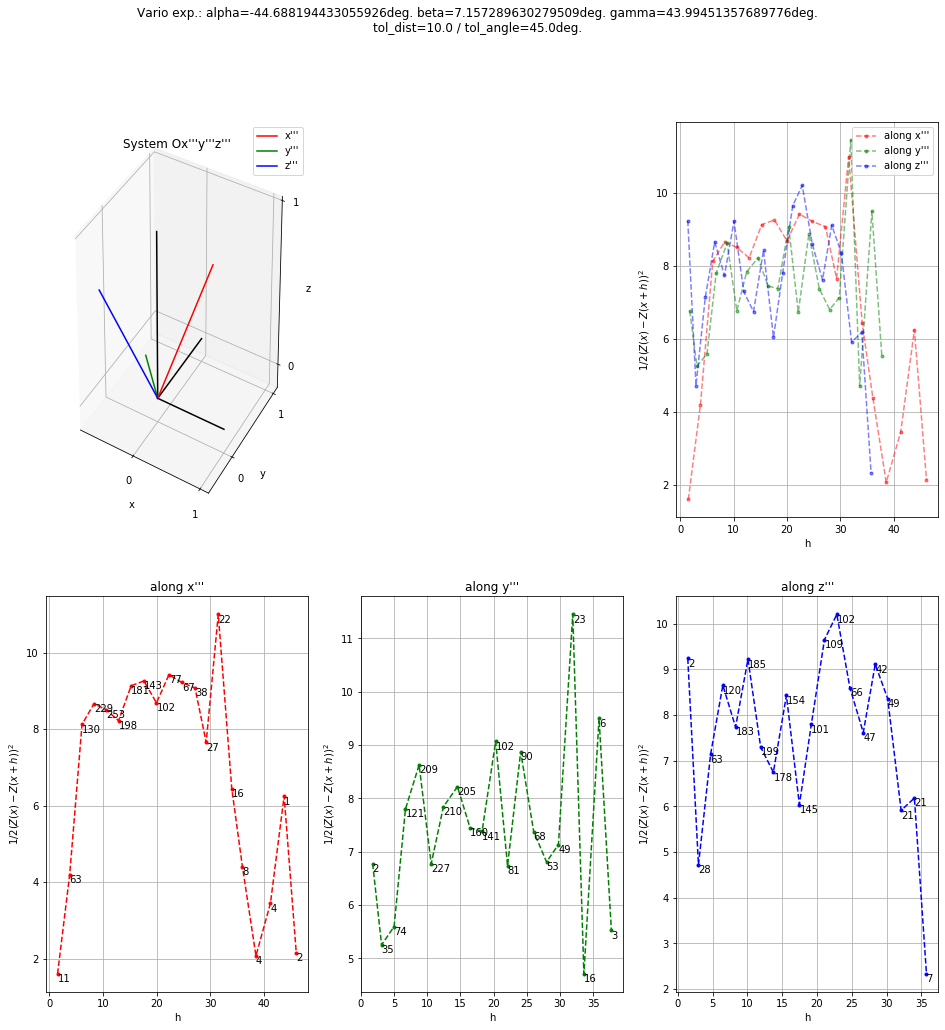

In [17]:
alpha_opt, beta_opt, gamma_opt = popt[-3:]
(hexp1, gexp1, cexp1), (hexp2, gexp2, cexp2), (hexp3, gexp3, cexp3) = gcm.variogramExp3D(x, v, 
    alpha=alpha_opt, beta=beta_opt, gamma=gamma_opt, ncla=(20,20,20), make_plot=True, figsize=(16,16))

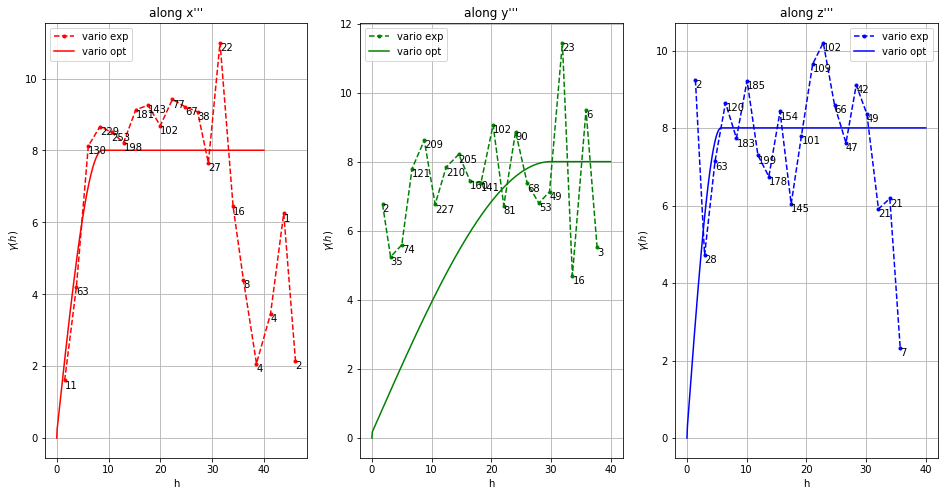

In [18]:
plt.subplots(1,3,figsize=(16,8))
plt.subplot(1,3,1)
gcm.plot_variogramExp1D(hexp1, gexp1, cexp1, c='red', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=1, hmax=40, c='red', label='vario opt')
plt.legend()
plt.title("along x'''")

plt.subplot(1,3,2)
gcm.plot_variogramExp1D(hexp2, gexp2, cexp2, c='green', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=2, hmax=40, c='green', label='vario opt')
plt.legend()
plt.title("along y'''")

plt.subplot(1,3,3)
gcm.plot_variogramExp1D(hexp3, gexp3, cexp3, c='blue', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=3, hmax=40, c='blue', label='vario opt')
plt.legend()
plt.title("along z'''")

plt.show()

### Cross-validation of covariance model by leave-one-out error
The function `cross_valid_loo` makes a cross-validation test by leave-one-out (LOO) error. Here, a data set in 3D and a covariance model in 3D are given.

See jupyter notebook `ex_vario_analysis_data1D` for more details about this function.

Model does not pass test for sum of square of normalized error (chi2)!
   Sum of squares of normalized error = 214.08344006934908, above limit: 178.48535274685938


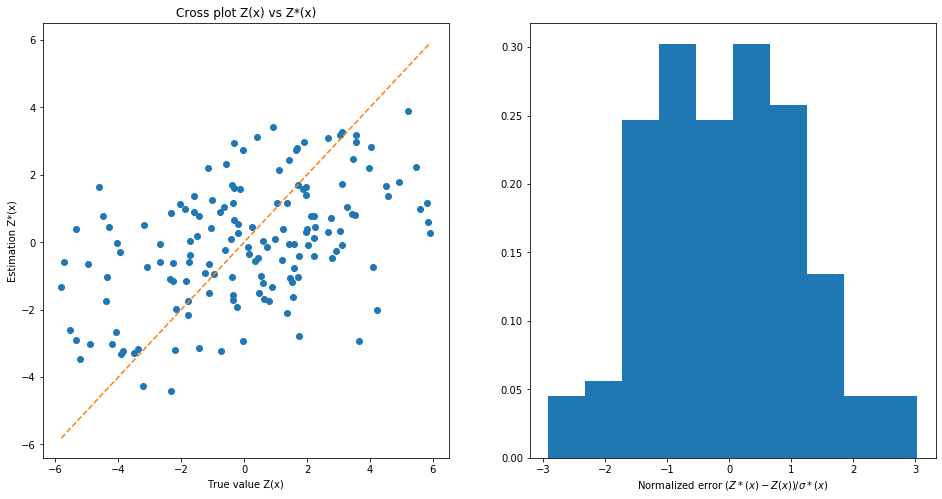

Test (1. normal law test for mean of normalized error) passed: True
Test (2. Chi2 test for sum of squares of normalized error) passed: False


In [19]:
# Interpolation by simple kriging
cv_est1, cv_std1, test_normal, test_chi2 = gcm.cross_valid_loo(x, v, cov_model_opt,
                                                               #interpolator_kwargs={'mean':np.mean(v)},
                                                               make_plot=True, figsize=(16,8))
plt.show()
print('\
Test (1. normal law test for mean of normalized error) passed: {}\n\
Test (2. Chi2 test for sum of squares of normalized error) passed: {}'.format(test_normal, test_chi2))

Model does not pass test for sum of square of normalized error (chi2)!
   Sum of squares of normalized error = 213.0537722513261, above limit: 178.48535274685938


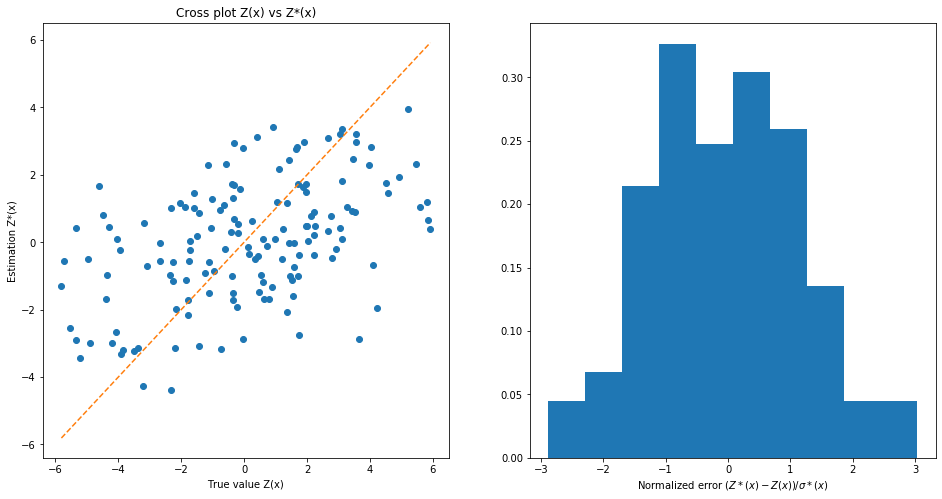

Test (1. normal law test for mean of normalized error) passed: True
Test (2. Chi2 test for sum of squares of normalized error) passed: False


In [20]:
# Interpolation by ordinary kriging
cv_est2, cv_std2, test_normal, test_chi2 = gcm.cross_valid_loo(x, v, cov_model_opt,
                                                               interpolator_kwargs={'method':'ordinary_kriging'},
                                                               make_plot=True, figsize=(16,8))
plt.show()
print('\
Test (1. normal law test for mean of normalized error) passed: {}\n\
Test (2. Chi2 test for sum of squares of normalized error) passed: {}'.format(test_normal, test_chi2))

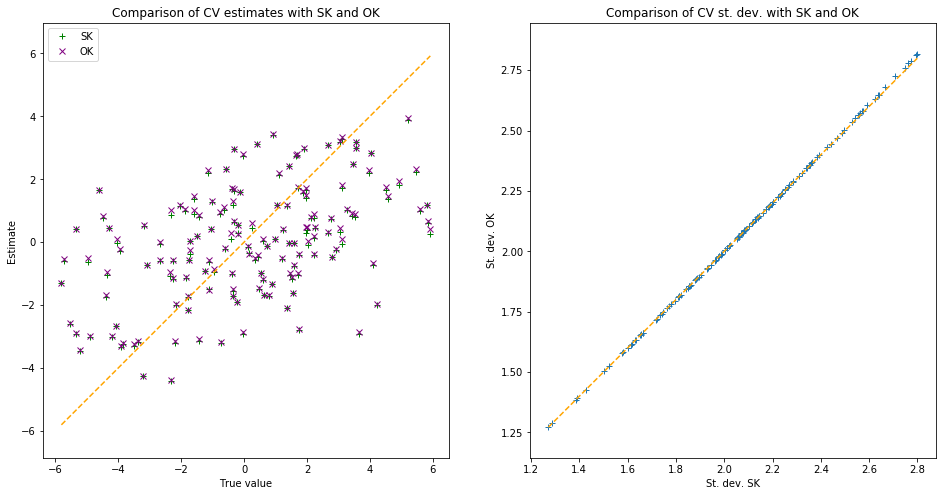

In [21]:
# Comparison of cross-validation with simple and kriging and ordinary kriging
plt.subplots(1, 2, figsize=(16,8))

plt.subplot(1,2,1)
# plt.plot(cv_est1, cv_est2, marker='+', ls='')
# plt.plot([np.min(cv_est1), np.max(cv_est1)], [np.min(cv_est1), np.max(cv_est1)], c='orange', ls='dashed')
# plt.axis('equal')
# plt.xlabel('Estimate SK')
# plt.ylabel('Estimate OK')
plt.plot(v, cv_est1, c='green', marker='+', ls='', label='SK')
plt.plot(v, cv_est2, c='purple', marker='x', ls='', label='OK')
plt.plot([np.min(v), np.max(v)], [np.min(v), np.max(v)], c='orange', ls='dashed')
plt.axis('equal')
plt.xlabel('True value')
plt.ylabel('Estimate')
plt.legend()
plt.title('Comparison of CV estimates with SK and OK')

plt.subplot(1,2,2)
plt.plot(cv_std1, cv_std2, marker='+', ls='')
plt.plot([np.min(cv_std1), np.max(cv_std1)], [np.min(cv_std1), np.max(cv_std1)], c='orange', ls='dashed')
plt.axis('equal')
plt.xlabel('St. dev. SK')
plt.ylabel('St. dev. OK')
plt.title('Comparison of CV st. dev. with SK and OK')
plt.show()

The second test failed, then the covariance model should be rejected! Then, the search for a convenient covariance model continues.

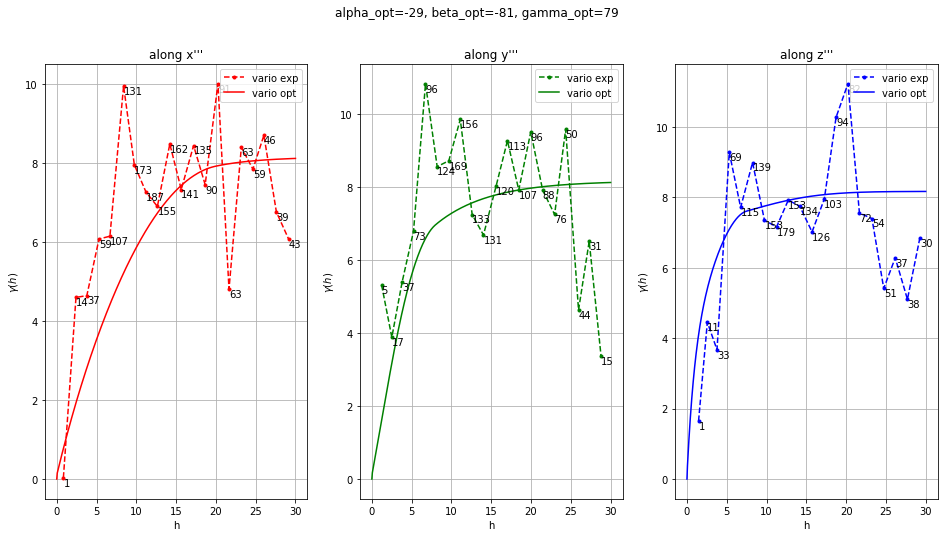

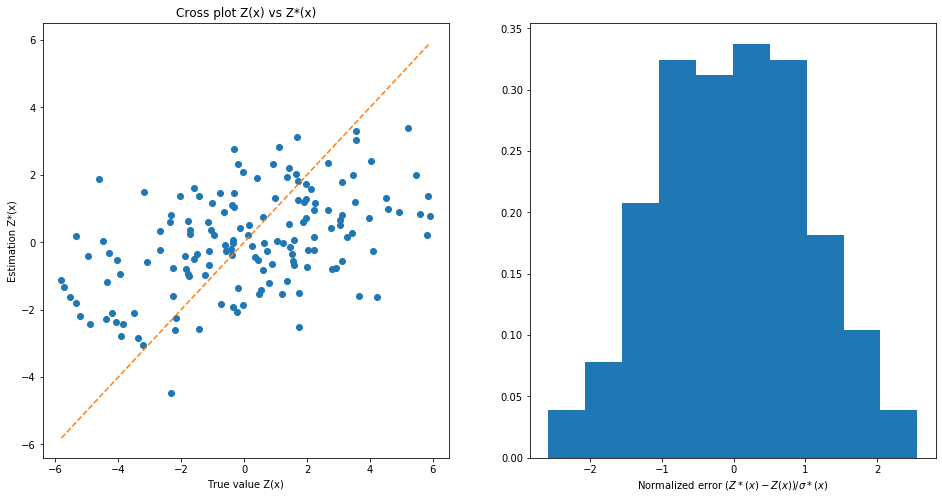

Test (1. normal law test for mean of normalized error) passed: True
Test (2. Chi2 test for sum of squares of normalized error) passed: True


Covariance model 3D: (Name = )
   4 elementary contribution(s)
   Elementary contribution 0: type : gaussian
      parameters:  w = 0.8490141922265452,  r = [19.99846329972967, 5.966104239940309, 19.995435007907297]
   Elementary contribution 1: type : spherical
      parameters:  w = 3.2348293350322104,  r = [19.999999999999996, 7.977449054503412, 7.48565357594717]
   Elementary contribution 2: type : exponential
      parameters:  w = 3.979636552107554,  r = [19.999999999999996, 19.999999999999996, 3.0127363182627964]
   Elementary contribution 3: type : nugget
      parameters:  w = 0.10000000000000002
   Angles: alpha = -28.758347680151726 deg., beta = -81.02703588598867 deg., gamma = 78.88477776944654 deg.
   i.e.: the system Ox'''y''''z''', supporting the axes of the model (ranges),
         is obtained from the system Oxyz as follows:
         Oxyz      -- rotation of angle -alpha around Oz  --> Ox'y'z'
         Ox'y'z'   -- rotation of angle -beta  around Ox' --> Ox''y''z''
   

In [22]:
# Model fitting 
cov_model_to_optimize = gcm.CovModel3D(
    elem=[('gaussian',    {'w':np.nan, 'r':[np.nan, np.nan, np.nan]}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':[np.nan, np.nan, np.nan]}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':[np.nan, np.nan, np.nan]}), # elementary contribution
          ('nugget',      {'w':np.nan})                        # elementary contribution
         ], alpha=np.nan, beta=np.nan, gamma=np.nan, name='')

# New optim. while limiting the distance between pair of points to 30 (hmax=30)
# and limiting max ranges to 20 (instead of 30 above)
hmax = 30
cov_model_opt, popt = gcm.covModel3D_fit(x, v, cov_model_to_optimize, hmax=hmax,
    bounds=([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  .1, -90, -90, -90],  # min value for param. to fit
            [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,   2,  90,  90,  90]), # max value for param. to fit
             # gaus. contr.,   sph. contr. ,   exp. contr. , nug., angles: alpha, beta, gamma
    make_plot=False)

# Experimental variograms
alpha_opt, beta_opt, gamma_opt = popt[-3:]
(hexp1, gexp1, cexp1), (hexp2, gexp2, cexp2), (hexp3, gexp3, cexp3) = gcm.variogramExp3D(x, v, 
    alpha=alpha_opt, beta=beta_opt, gamma=gamma_opt, hmax=(hmax, hmax, hmax), ncla=(20,20,20), make_plot=False)

# Figure: optimal vario and exp. vario along main axes given by alpha_opt, beta_opt, gamma_opt
plt.subplots(1,3,figsize=(16,8))
plt.subplot(1,3,1)
gcm.plot_variogramExp1D(hexp1, gexp1, cexp1, c='red', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax, c='red', label='vario opt')
plt.legend()
plt.title("along x'''")

plt.subplot(1,3,2)
gcm.plot_variogramExp1D(hexp2, gexp2, cexp2, c='green', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax, c='green', label='vario opt')
plt.legend()
plt.title("along y'''")

plt.subplot(1,3,3)
gcm.plot_variogramExp1D(hexp3, gexp3, cexp3, c='blue', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=3, hmax=hmax, c='blue', label='vario opt')
plt.legend()
plt.title("along z'''")

plt.suptitle('alpha_opt={:.2g}, beta_opt={:.2g}, gamma_opt={:.2g}'.format(alpha_opt, beta_opt, gamma_opt))
plt.show()

# Cross-validation (interpolation by simple kriging)
cv_est, cv_std, test_normal, test_chi2 = gcm.cross_valid_loo(x, v, cov_model_opt,
                                                             #interpolator_kwargs={'mean':np.mean(v)},
                                                             make_plot=True, figsize=(16,8))
plt.show()
print('\
Test (1. normal law test for mean of normalized error) passed: {}\n\
Test (2. Chi2 test for sum of squares of normalized error) passed: {}'.format(test_normal, test_chi2))
cov_model_opt

**Note:** the following illustrations are similar to what is done in the jupyter notebook `ex_vario_analysis_data3D_1_omnidirectional`.

### Data interpolation by (simple or ordinary) kriging: function `gcm.krige`
The function `gcm.krige(x, v, xu, cov_model, method='simple_kriging', mean=None)` return the kriging estimates and standard deviation at location `xu`, given the data points located at `x` with value `v` and the covariance model `cov_model`. Type of kriging is determined by the keyword argument `method`:
- `method='simple_kriging'` (default): simple kriging is used, with the mean automatically set to the mean of the data values (`mean=None`); a specified mean value or array (for non-stationary mean) can be set manually with the keyword argument `mean`.
- `method='ordinary_kriging'`: ordinary kriging is used (the keyword argument `mean` is ignored (not used))

For data in 3D:
- `x`: 2-dimensional array of shape `(n, 3)`, location of data points (each row is a point),
- `v`: 1-dimensional array of length `n`, values at data points,
- `xu`: 2-dimensional array of shape `(m, 3)` location of points where the interpolation is done. 

In return:
- `vu`: 1-dimensional array of length `m`, kriging estimates at location `xu`,
- `vu_std`: 1-dimensional array of length `m`, kriging standard deviation at location `xu`.

In [23]:
# Define points xu where to interpolate
# ... location of the 3D-grid used to build the data set (but it could be different)
xcu = ox + (np.arange(nx)+0.5)*dx # x-coordinates of points
ycu = oy + (np.arange(ny)+0.5)*dy # y-coordinates of points
zcu = oz + (np.arange(nz)+0.5)*dz # z-coordinates of points
zzcu, yycu, xxcu = np.meshgrid(zcu, ycu, xcu, indexing='ij')
xu = np.array((xxcu.reshape(-1), yycu.reshape(-1), zzcu.reshape(-1))).T # 2-dimensional array 
                                                                        # of shape nx*ny*nz x 3

# Simple kriging
vu, vu_std = gcm.krige(x, v, xu, cov_model_opt, method='simple_kriging')
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu

# Fill image (Img class from geone.img) for view
#   variable 0: kriging estimates
#   variable 1: kriging standard deviation
im_krig = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=2, val=np.array((vu, vu_std)))

In [24]:
# Preparation for plot...
# Set data_points: to be added to 3D plot
data_points = pv.PolyData(x)

# ... set color for data points according to their value
cmap = plt.get_cmap('terrain') # color map
cmin = im_krig.vmin()[0] # min value of kriging estimates
cmax = im_krig.vmax()[0] # max value of kriging estimates
data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points['colors'] = data_points_col

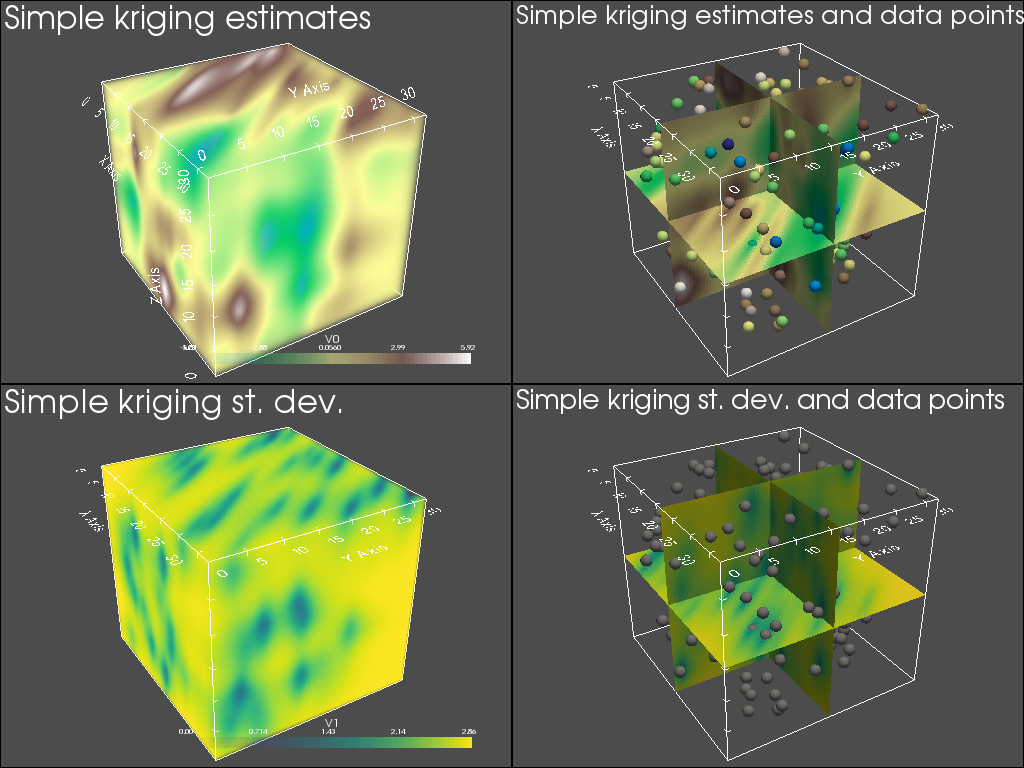

In [25]:
# Plot "interactive" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_krig, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Simple kriging estimates') # title
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im_krig, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='Simple kriging estimates and data points') # title                          
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
imgplt3.drawImage3D_volume(im_krig, iv=1, plotter=pp, cmap='viridis',
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Simple kriging st. dev.') # title
pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_krig, iv=1, plotter=pp, cmap='viridis',
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='Simple kriging st. dev. and data points') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

In [26]:
# Define points xu where to interpolate
# ... location of the 3D-grid used to build the data set (but it could be different)
xcu = ox + (np.arange(nx)+0.5)*dx # x-coordinates of points
ycu = oy + (np.arange(ny)+0.5)*dy # y-coordinates of points
zcu = oz + (np.arange(nz)+0.5)*dz # z-coordinates of points
zzcu, yycu, xxcu = np.meshgrid(zcu, ycu, xcu, indexing='ij')
xu = np.array((xxcu.reshape(-1), yycu.reshape(-1), zzcu.reshape(-1))).T # 2-dimensional array 
                                                                        # of shape nx*ny*nz x 3

# Ordinary kriging
vu, vu_std = gcm.krige(x, v, xu, cov_model_opt, method='ordinary_kriging')
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu

# Fill image (Img class from geone.img) for view
#   variable 0: kriging estimates
#   variable 1: kriging standard deviation
im_krig = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=2, val=np.array((vu, vu_std)))

In [27]:
# Preparation for plot...
# Set data_points: to be added to 3D plot
data_points = pv.PolyData(x)

# ... set color for data points according to their value
cmap = plt.get_cmap('terrain') # color map
cmin = im_krig.vmin()[0] # min value of kriging estimates
cmax = im_krig.vmax()[0] # max value of kriging estimates
data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points['colors'] = data_points_col

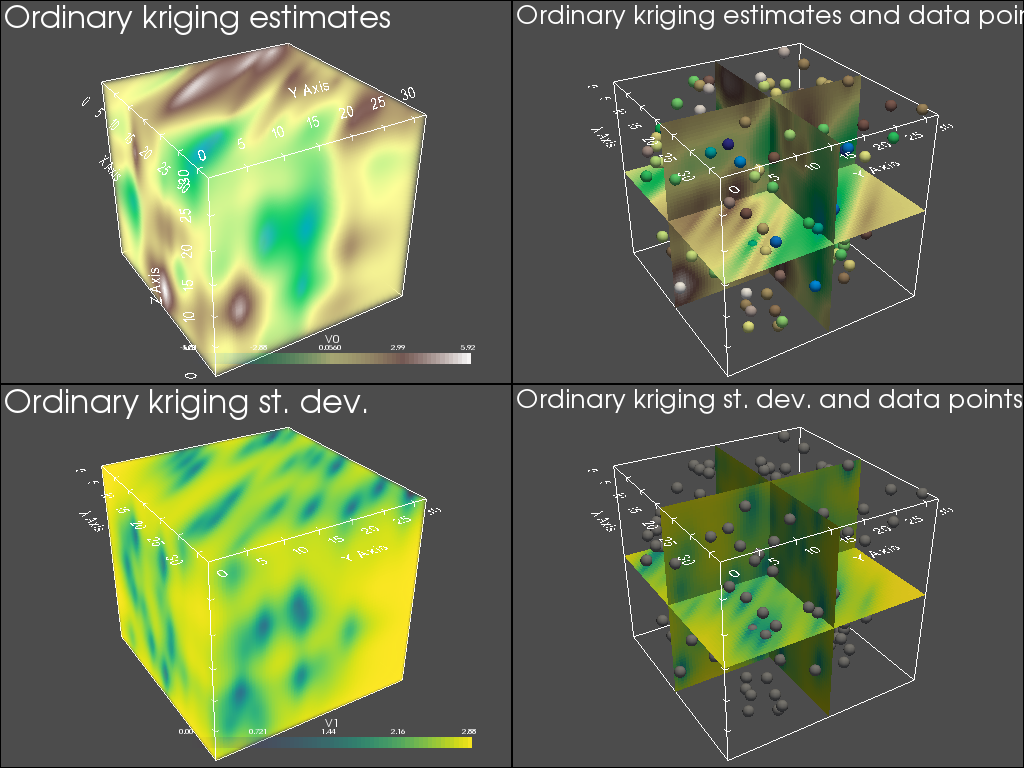

In [28]:
# Plot "interactive" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_krig, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Ordinary kriging estimates') # title
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im_krig, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='Ordinary kriging estimates and data points') # title                          
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
imgplt3.drawImage3D_volume(im_krig, iv=1, plotter=pp, cmap='viridis',
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Ordinary kriging st. dev.') # title
pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_krig, iv=1, plotter=pp, cmap='viridis',
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='Ordinary kriging st. dev. and data points') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

## Alternatives for kriging estimation and simulation
The module `geone.geosclassicinterface` allows to perform kriging interpolation (estimation) and simulation (sequential Gaussian simulation, SGS) (see jupyter notebook `ex_geosclassic_3d` for 3D case):
- function `estimate3D`: estimation in a 3D grid, *i.e* kriging estimates and standard deviation, for simple or ordinary kriging
- function `simulate3D`: simulation in a 3D grid, based on simple or ordinary kriging; allows also to handle inequality data

The module `geone.grf` allows to perform kriging interpolation (estimation) and simulation (sequential Gaussian simulation, SGS) (see jupyter notebook `ex_geosclassic_3d` for 3D case):
- function `krige3D`: estimation a 3D grid, *i.e* kriging estimates and standard deviation, for simple kriging only
- function `grf3D`: simulation a 3D grid, based on simple kriging only

Note that for these functions, the conditioning values will be attached to the grid cells containing the corresponding conditioning locations.

### Estimation using the function `gcm.krige`

In [29]:
t1 = time.time()
vu, vu_std = gcm.krige(x, v, xu, cov_model_opt, method='simple_kriging')
t2 = time.time()
print('Elapsed time in seconds: {}'.format(t2-t1))

Elapsed time in seconds: 9.531874895095825


### Estimation using the function `grf.krige3D`

In [30]:
t1 = time.time()
vu_grf, vu_std_grf = grf.krige3D(x, v, cov_model_opt, (nx, ny, nz), (dx, dy, dz), (ox, oy, oz), printInfo=False)
t2 = time.time()
print('Elapsed time in seconds: {}'.format(t2-t1))

Elapsed time in seconds: 3.3160030841827393


### Estimation using the function `gci.estimate3D`

In [31]:
t1 = time.time()
estim_gci = gci.estimate3D(cov_model_opt, (nx, ny, nz), (dx, dy, dz), (ox, oy, oz), x=x, v=v, 
                           method='simple_kriging', nneighborMax=24, verbose=0)
t2 = time.time()
print('Elapsed time in seconds: {}'.format(t2-t1))

Elapsed time in seconds: 25.125940561294556


### Plot results of estimation

In [32]:
# Fill images (Img class from geone.img) for view
#   variable 0: kriging estimates
#   variable 1: kriging standard deviation
im_krig = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=2, val=np.array((vu, vu_std)))
im_grf = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=2, val=np.array((vu_grf, vu_std_grf)))
im_gci = estim_gci['image']

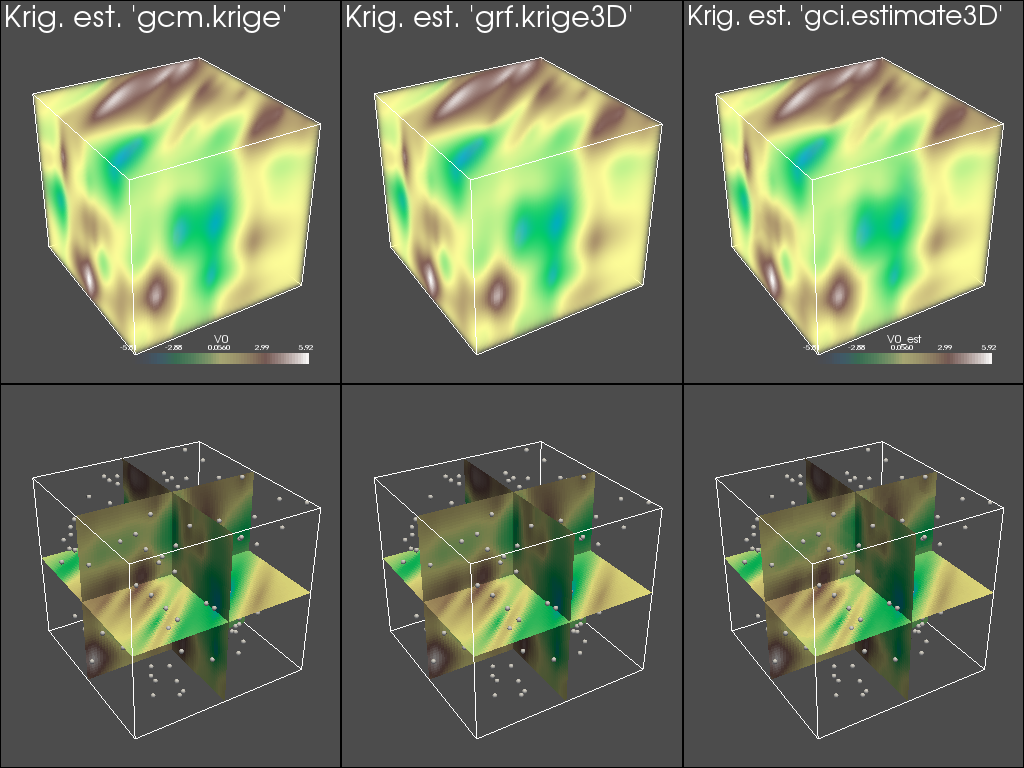

In [33]:
# Plot kriging estimates

# Plot "interactive" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,3), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,3))

pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_krig, iv=0, plotter=pp, cmap='terrain',
                           text="Krig. est. 'gcm.krige'") # title

pp.subplot(0, 1)
imgplt3.drawImage3D_volume(im_grf, iv=0, plotter=pp, cmap='terrain',
                           text="Krig. est. 'grf.krige3D'") # title

pp.subplot(0, 2)
imgplt3.drawImage3D_volume(im_gci, iv=0, plotter=pp, cmap='terrain',
                           text="Krig. est. 'gci.estimate3D'") # title

pp.subplot(1, 0)
imgplt3.drawImage3D_slice(im_krig, iv=0, plotter=pp, cmap='terrain',
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_grf, iv=0, plotter=pp, cmap='terrain',
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 2)
imgplt3.drawImage3D_slice(im_gci, iv=0, plotter=pp, cmap='terrain',
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

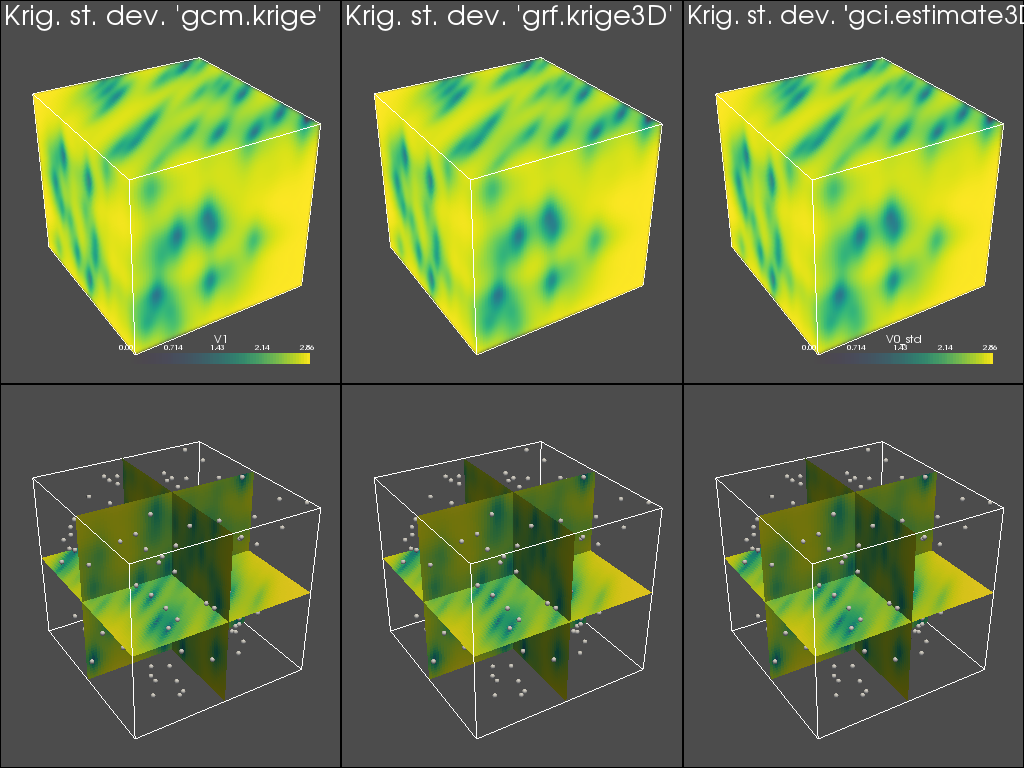

In [34]:
# Plot kriging standard deviation

# Plot "interactive" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,3), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,3))

pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_krig, iv=1, plotter=pp, cmap='viridis',
                           text="Krig. st. dev. 'gcm.krige'") # title

pp.subplot(0, 1)
imgplt3.drawImage3D_volume(im_grf, iv=1, plotter=pp, cmap='viridis',
                           text="Krig. st. dev. 'grf.krige3D'") # title

pp.subplot(0, 2)
imgplt3.drawImage3D_volume(im_gci, iv=1, plotter=pp, cmap='viridis',
                           text="Krig. st. dev. 'gci.estimate3D'") # title

pp.subplot(1, 0)
imgplt3.drawImage3D_slice(im_krig, iv=1, plotter=pp, cmap='viridis',
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_grf, iv=1, plotter=pp, cmap='viridis',
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 2)
imgplt3.drawImage3D_slice(im_gci, iv=1, plotter=pp, cmap='viridis',
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

In [35]:
print("Peak-to-peak estimation   'gcm.krige - grf.krige2D'    = {}".format(np.ptp(im_krig.val[0] - im_grf.val[0])))
print("Peak-to-peak estimation   'gcm.krige - gci.estimate2D' = {}".format(np.ptp(im_krig.val[0] - im_gci.val[0])))
print("Peak-to-peak estimation 'grf.krige2D - gci.estimate2D' = {}".format(np.ptp(im_grf.val[0] - im_gci.val[0])))
print("Peak-to-peak st. dev.   'gcm.krige - grf.krige2D'    = {}".format(np.ptp(im_krig.val[1] - im_grf.val[1])))
print("Peak-to-peak st. dev.   'gcm.krige - gci.estimate2D' = {}".format(np.ptp(im_krig.val[1] - im_gci.val[1])))
print("Peak-to-peak st. dev. 'grf.krige2D - gci.estimate2D' = {}".format(np.ptp(im_grf.val[1] - im_gci.val[1])))

Peak-to-peak estimation   'gcm.krige - grf.krige2D'    = 0.000467639001778819
Peak-to-peak estimation   'gcm.krige - gci.estimate2D' = 1.8388631970751328
Peak-to-peak estimation 'grf.krige2D - gci.estimate2D' = 1.8388631926387413
Peak-to-peak st. dev.   'gcm.krige - grf.krige2D'    = 6.233161675694987e-08
Peak-to-peak st. dev.   'gcm.krige - gci.estimate2D' = 0.03607288037519574
Peak-to-peak st. dev. 'grf.krige2D - gci.estimate2D' = 0.036072820778280335


### Conditional simulation using the function `grf.grf3D`

In [36]:
np.random.seed(293)

t1 = time.time()
nreal = 20
sim_grf = grf.grf3D(cov_model_opt, (nx, ny, nz), (dx, dy, dz), (ox, oy, oz), x=x, v=v, 
                    nreal=nreal, printInfo=False)
t2 = time.time()
print('Elapsed time in seconds: {}'.format(t2-t1))

Elapsed time in seconds: 8.74433183670044


### Conditional simulation using the function `grci.simulate3D`

In [37]:
np.random.seed(293)

t1 = time.time()
nreal = 20
sim_gci = gci.simulate3D(cov_model_opt, (nx, ny, nz), (dx, dy, dz), (ox, oy, oz), x=x, v=v, 
                         nreal=nreal, method='simple_kriging', verbose=0)
t2 = time.time()
print('Elapsed time in seconds: {}'.format(t2-t1))

Elapsed time in seconds: 15.739413261413574


### Plot some realizations and compare to the reference simulation

In [38]:
# Fill images (Img class from geone.img) for view
#   variable i: i-th realization
im_sim_grf = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=nreal, val=sim_grf)
im_sim_gci = sim_gci['image']

# min and max over all real and ref. sim
im_vmin = min(np.min(im_sim_grf.vmin()), np.min(im_sim_gci.vmin()), im_ref.vmin()[0]) 
im_vmax = max(np.max(im_sim_grf.vmax()), np.min(im_sim_gci.vmax()), im_ref.vmax()[0]) 

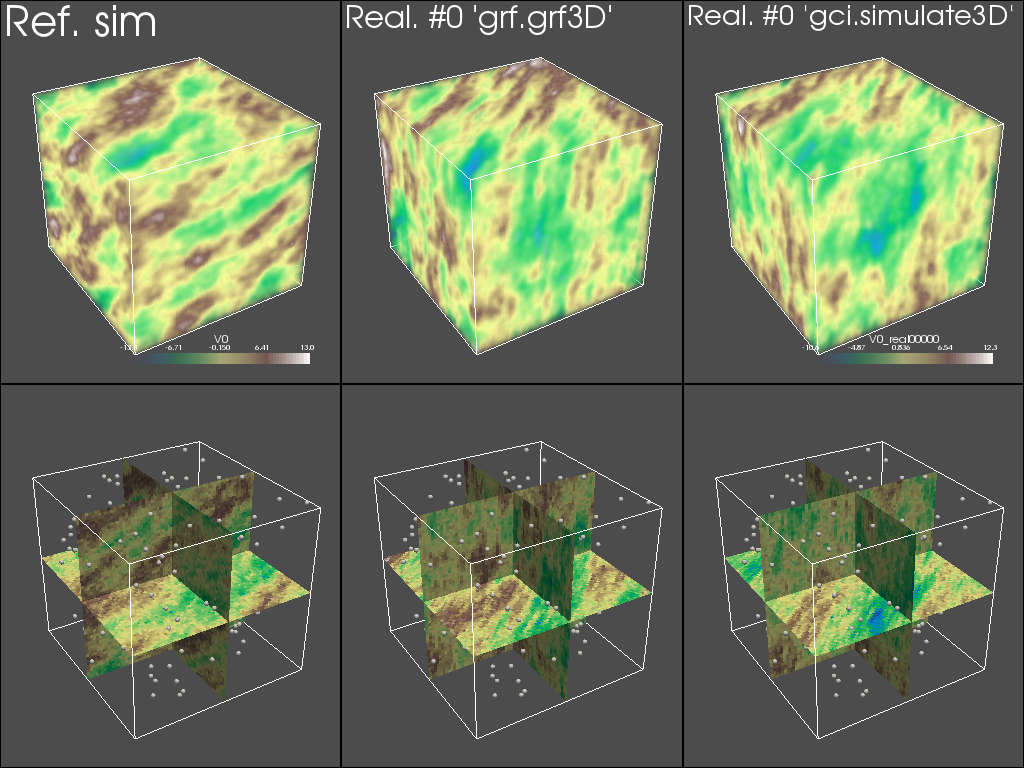

In [39]:
# Plot "interactive" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,3), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,3))

pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_ref, iv=0, plotter=pp, cmap='terrain',
                           text="Ref. sim") # title

pp.subplot(0, 1)
imgplt3.drawImage3D_volume(im_sim_grf, iv=0, plotter=pp, cmap='terrain',
                           text="Real. #0 'grf.grf3D'") # title

pp.subplot(0, 2)
imgplt3.drawImage3D_volume(im_sim_gci, iv=0, plotter=pp, cmap='terrain',
                           text="Real. #0 'gci.simulate3D'") # title

pp.subplot(1, 0)
imgplt3.drawImage3D_slice(im_ref, iv=0, plotter=pp, cmap='terrain',
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_sim_grf, iv=0, plotter=pp, cmap='terrain',
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 2)
imgplt3.drawImage3D_slice(im_sim_gci, iv=0, plotter=pp, cmap='terrain',
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

The retained optimal covariance model has angles differing from those of the reference covariance model (which is considered unknown!), this is why the orientations of the structures slightly differ comparing the realizations above and the reference.

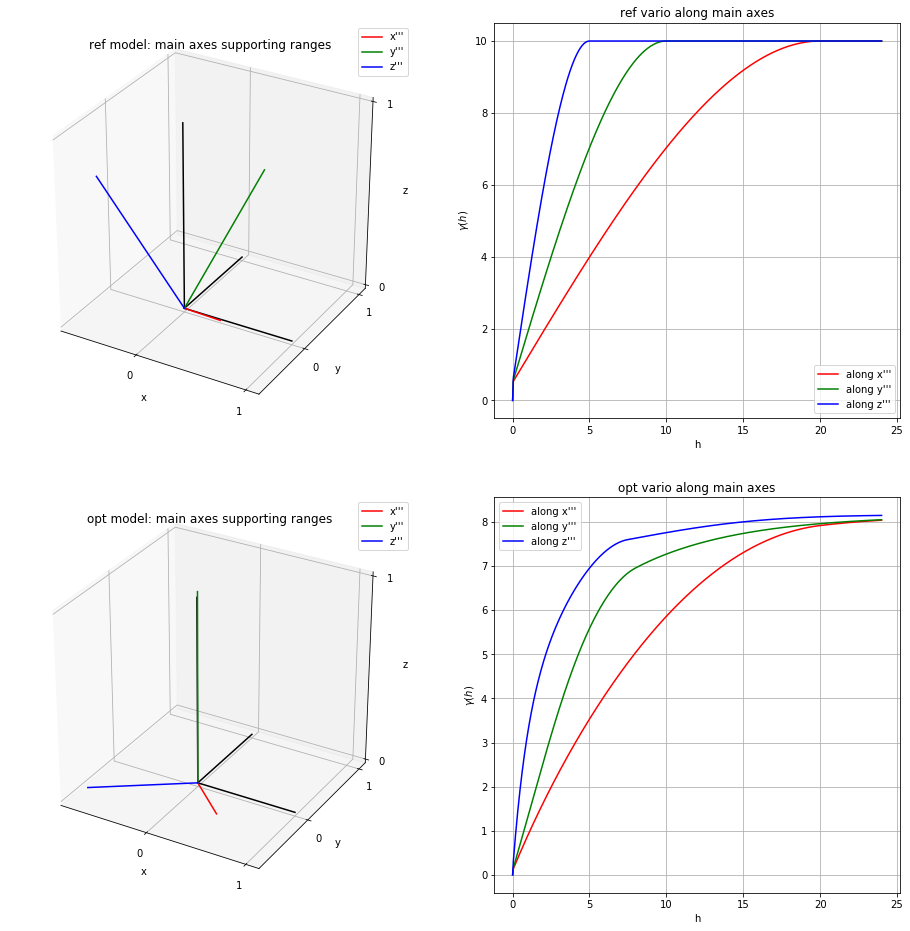

In [40]:
# Comparison of "optimal model" and "reference model"
fig = plt.figure(figsize=(16,16))

# ...plot main axes (ref model)
fig.add_subplot(2,2,1, projection='3d')
cov_model_ref.plot_mrot(set_3d_subplot=False)
plt.title('ref model: main axes supporting ranges')

# ...plot variogram model curves along each main axis (ref model)
fig.add_subplot(2,2,2)
cov_model_ref.plot_model_curves(vario=True)
plt.title('ref vario along main axes')

# ...plot main axes (opt model)
fig.add_subplot(2,2,3, projection='3d')
cov_model_opt.plot_mrot(set_3d_subplot=False)
plt.title('opt model: main axes supporting ranges')

# ...plot variogram model curves along each main axis (opt model)
fig.add_subplot(2,2,4)
cov_model_opt.plot_model_curves(vario=True)
plt.title('opt vario along main axes')

plt.show()